## Sales forecasting using SARIMA model

In [35]:
#import the necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings('ignore')

In [36]:
#read the various datasets available(train and test dataset)
df=pd.read_csv('train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [37]:
df.shape

(913000, 4)

In [38]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

There are no null values present

In [39]:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [40]:
#converting date column to datetime datatype
df['date']=pd.to_datetime(df['date'])

In [41]:
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [42]:
#Create new columns based on date column
df['month'] = df['date'].apply(lambda x:x.month)
df['day_of_month'] = df['date'].apply(lambda x:x.day)
df['year'] = df['date'].apply(lambda x:x.year)

In [43]:
df.head()

,date,store,item,sales,month,day_of_month,year
0,2013-01-01,1,1,13,1,1,2013
1,2013-01-02,1,1,11,1,2,2013
2,2013-01-03,1,1,14,1,3,2013
3,2013-01-04,1,1,13,1,4,2013
4,2013-01-05,1,1,10,1,5,2013


In [46]:
df_monthly_sales=df.groupby(['item','store','year','month']).agg(total_sales=("sales", 'sum'))
df_monthly_sales = df_monthly_sales.reset_index()

In [47]:
df_monthly_sales.head()

,item,store,year,month,total_sales
0,1,1,2013,1,328
1,1,1,2013,2,322
2,1,1,2013,3,477
3,1,1,2013,4,522
4,1,1,2013,5,531


In [48]:
#number of unique stores
df['store'].nunique()

10

In [49]:
#number of unique items
df['item'].nunique()

50

In [50]:
df_monthly_sales['date'] = pd.to_datetime(df_monthly_sales['year'].astype(str) + '-' + df_monthly_sales['month'].astype(str) + '-' + '1')

In [51]:
df_monthly_sales.dtypes

item                    int64
store                   int64
year                    int64
month                   int64
total_sales             int64
date           datetime64[ns]
dtype: object

In [52]:
df_monthly_sales.head()

,item,store,year,month,total_sales,date
0,1,1,2013,1,328,2013-01-01
1,1,1,2013,2,322,2013-02-01
2,1,1,2013,3,477,2013-03-01
3,1,1,2013,4,522,2013-04-01
4,1,1,2013,5,531,2013-05-01


In [54]:
# grouping by average of sales across stores for each item
avg_monthly_sales=df_monthly_sales.groupby(['item','date']).agg(avg_sales=("total_sales", 'mean'))
avg_monthly_sales = avg_monthly_sales.reset_index()
avg_monthly_sales.head()

,item,date,avg_sales
0,1,2013-01-01,379.4
1,1,2013-02-01,386.3
2,1,2013-03-01,519.0
3,1,2013-04-01,578.3
4,1,2013-05-01,629.8


#### Average sales pattern for various items from 2013 to 2017

Text(0.5, 1.0, 'Average monthly sales time series chart for item1 to item 50')

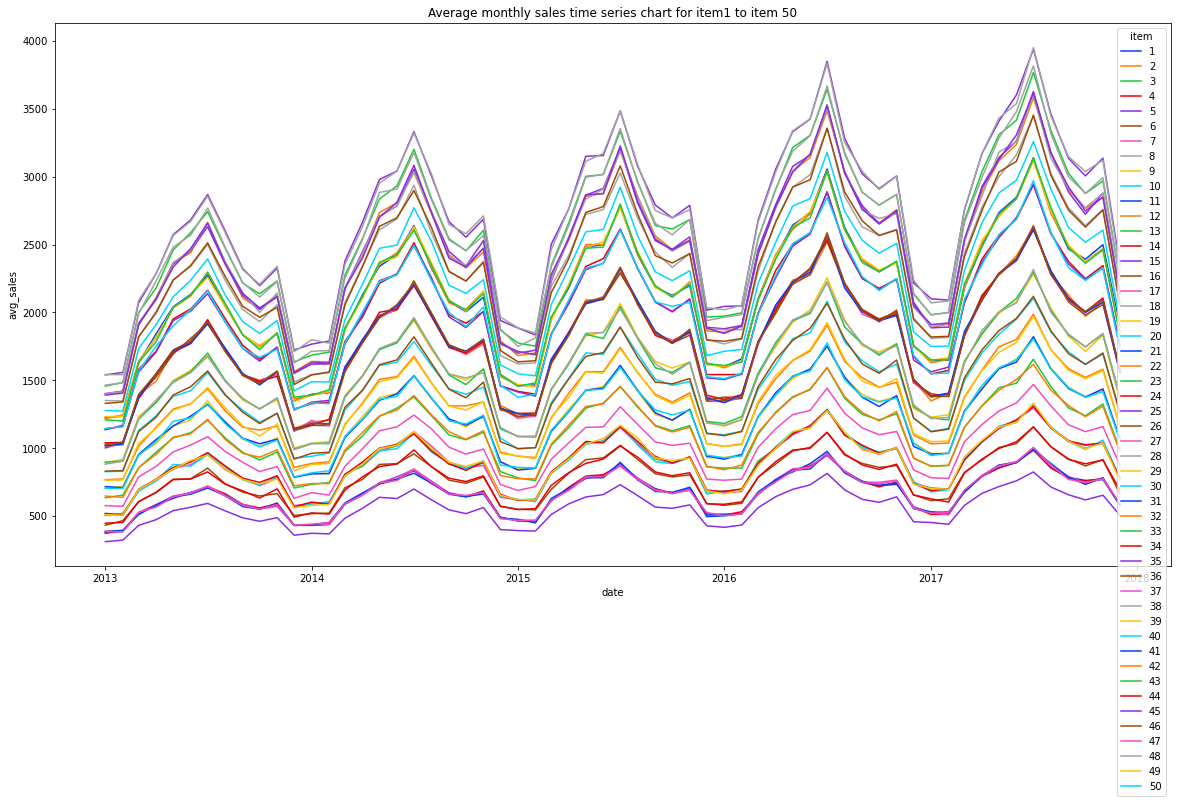

In [56]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=avg_monthly_sales, x="date", y="avg_sales", hue="item",palette='bright')
plt.title('Average monthly sales time series chart for item1 to item 50')

From the above graph it can be clearly understood that the sales for all items are seasonal across each year and has a slightly increasing trend

Hence we can go for Seasonal ARIMA model for forecasting

#### Choosing one item for further testing and model building

In [57]:
# separating item1 from the dataset for further analysis since all items follow more or less the similar pattern
item1=all_stores_avgmonthly_sales.loc[all_stores_avgmonthly_sales['item']==1]
item1.drop(columns=['item'],inplace=True)
item1=item1.set_index('date')

<AxesSubplot:title={'center':'Average monthly sales of item1 from 2013-2017'}, xlabel='date'>

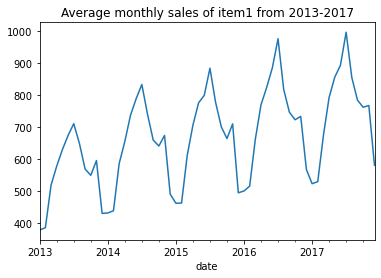

In [58]:
item1.plot(title='Average monthly sales of item1 from 2013-2017',legend=False)        

### Testing for stationarity

In [59]:
#H0/ Null hypothesis: It is non stationary
#H1/ Alternate hypothesis: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("There is strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("There is weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [60]:
adfuller_test(item1['avg_sales'])#considering item1 sales

ADF Test Statistic : -4.926311641554751
p-value : 3.098679702840348e-05
#Lags Used : 11
Number of Observations Used : 48
There is strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Here we can see that the data is stationary

### Time series decomposition

In [65]:
# import seasonal_decompose
decomposition = seasonal_decompose(item1['avg_sales'])

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

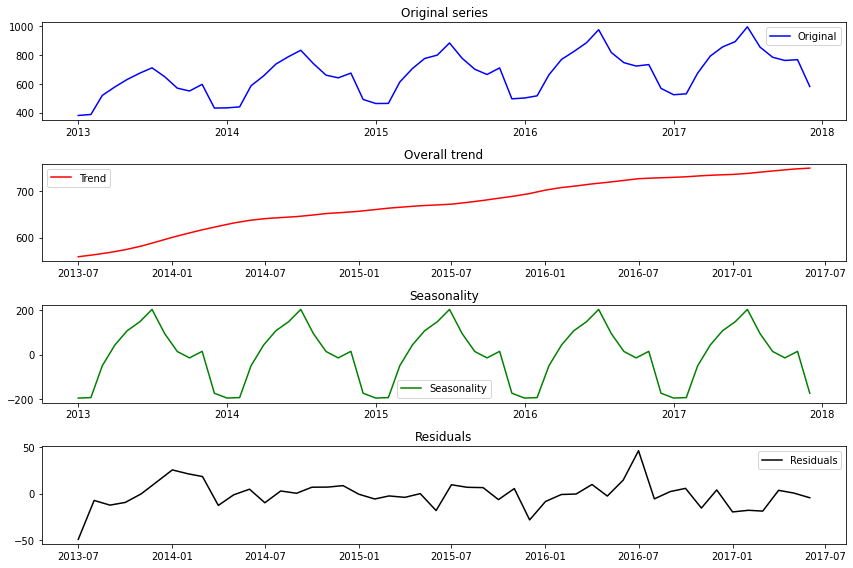

In [66]:
# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(item1['avg_sales'], label='Original', color="blue")
plt.title('Original series')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="red")
plt.title('Overall trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="green")
plt.title('Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="black")
plt.title('Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Autocorrelation and partial autocorrelation

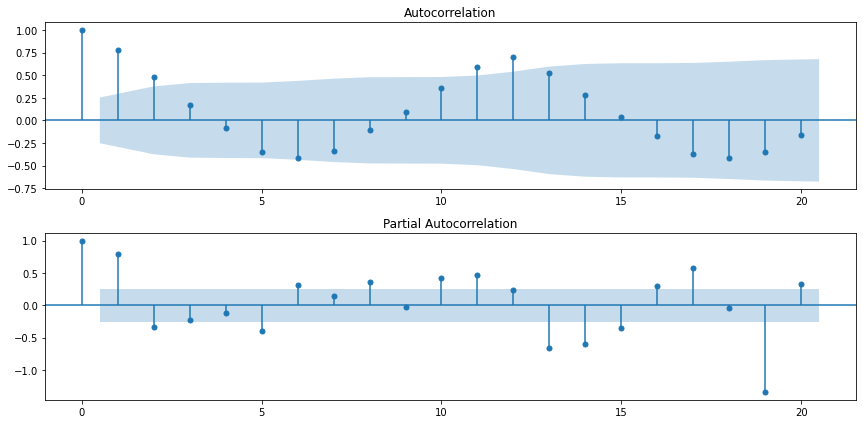

In [69]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(item1['avg_sales'],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(item1['avg_sales'],lags=20,ax=ax2)
plt.tight_layout()

### Finding orders for trend and seasonal elements for SARIMA via grid search

In [70]:
def AIC_PDQS(df):   
    ''' 
         Runs grid search to return lowest AIC result for permutataions of pdq/s values in range 0,2  
                          
         df          Dataframe to anlyse for best pdq/s permutation    
    '''
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 3)
    
#     Auto-Regressive (p) -> Number of autoregressive terms.
#     Integrated (d) -> Number of nonseasonal differences needed for stationarity.
#     Moving Average (q) -> Number of lagged forecast errors in the prediction equation.

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df

In [71]:
AIC_PDQS(item1)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =940.5628983029245
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =714.3893594283248
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =519.9126384752607
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =515.1521376593585
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1417.3043735466044
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =235.99716095942387
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =369.55399686527466
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =225.57123021545445
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =103.96499933489554
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =470.6092996834789
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =450.44416845380607
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =306.0784712115297
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =351.71438028172815
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1469.8603028346483
ARIMA (0, 0,

ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =292.6998203199392
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =309.74692061796173
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1139.5423654840067
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =181.00816072072826
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =206.13227502150298
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =190.04843526950543
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =83.16900693966215
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =301.62212531648004
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =307.68097248383015
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =289.4796455395283
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =193.33376766476587
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =767.140321126841
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =181.73042401995104
ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =96.16159144777396
ARIMA (0, 1,

ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =277.5655172264425
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =193.3975325578542
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =955.5612693782718
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =168.3210835596425
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =86.90970243398482
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =87.8557598409241
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =68.03011514244707
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =703.2376775179132
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =531.834201072828
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =392.5553897217677
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =425.6382078556617
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1324.8607316346902
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =210.56423031386228
ARIMA (1, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =351.9374857278812
ARIMA (1, 0, 0) x (0

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =367.5339204151096
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =408.2762110292692
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1377.851763247054
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =190.21395933391628
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =335.5689226649344
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =199.63030436204187
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =82.98686183440545
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =416.7109371070471
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =400.82339975671835
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =290.86303037743676
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =303.3504032551996
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1300.7994305111015
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =180.5926059180937
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =199.44080864541485
ARIMA (1, 1, 1

ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =285.03925564712375
ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =301.7672308928826
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =1460.7517131448597
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =166.67177657741007
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =197.97260742485884
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =179.65086902988799
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =71.65599676710411
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =292.04383252591543
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =309.30994776934824
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =279.73026799858064
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =184.94067955394107
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =855.1815467581818
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =168.88618060843623
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =79.23357059157003
ARIMA (1, 

ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =287.34723597034395
ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =179.54739709422967
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =676.1018034718443
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =183.2604801481366
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =81.59537919326362
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =83.42039950566348
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =85.51672280687603
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =668.6669224885931
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =500.70720202860497
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =365.39925708534554
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =408.9025975888933
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1127.5403995828676
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =186.84864392018662
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =337.38895636214585
ARIMA (2, 1, 

ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =349.2692451857713
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =397.0232237891156
ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =1026.541068388421
ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =174.1947033130821
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =323.28128112398394
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =188.7429768786079
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =71.35013550983027
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =406.5182652940716
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =391.6788053458831
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =282.11329985547115
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =292.70018812814584
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =1246.8264431348805
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =167.03924202617213
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =191.4972711077983
ARIMA (2, 2, 2)

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",940.562898
1,"(0, 0, 0)","(0, 0, 1, 12)",714.389359
2,"(0, 0, 0)","(0, 0, 2, 12)",519.912638
3,"(0, 0, 0)","(0, 1, 0, 12)",515.152138
4,"(0, 0, 0)","(0, 1, 1, 12)",1417.304374
...,...,...,...
724,"(2, 2, 2)","(2, 1, 1, 12)",869.714171
725,"(2, 2, 2)","(2, 1, 2, 12)",170.139192
726,"(2, 2, 2)","(2, 2, 0, 12)",75.491782
727,"(2, 2, 2)","(2, 2, 1, 12)",85.614779


From the above output it can be observed that the lowest AIC value of 10.0 is observed for (1,1,2)x(0,1,1,12)

### Train-Test split and fitting the SARIMA model to train dataset

In [74]:
def train_test(df):
    ''' 
        Sets train and test data for period of prediction     
                         
        df          Dataframe to create split   
    '''

    #Set training data before 2017
    train = df[:'2016-06']
    #Set test data starting 2017
    test = df['2016-07':]
    plt.plot(train,label='Train')
    plt.plot(test,label='Test')
    plt.title('Dataset split for training and testing purpose')
    return train, test

def model_fit(df,pdq,pdqs):
    ''' 
        Performs SARAMA model given defined pdq/s values and returns results     
        
        df          Dataframe to Analyse   
        
        Returns train/test df on the same df modelled   
    '''

    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs, enforce_stationarity=False, 
                                        enforce_invertibility=False)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary().tables[1])
    #results.plot_diagnostics(figsize=(14,10))
    #plt.show();
    return train, test, results,model

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5844      1.290     -0.453      0.650      -3.112       1.943
ma.L1         -0.1531      1.192     -0.128      0.898      -2.490       2.183
ma.L2         -0.1555      0.888     -0.175      0.861      -1.896       1.585
ma.S.L12      -0.2069      0.228     -0.906      0.365      -0.655       0.241
sigma2       325.1073    183.952      1.767      0.077     -35.433     685.648


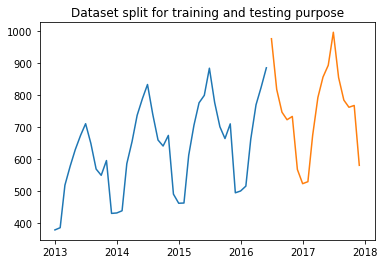

In [75]:
# Optimum values based on grid search with least aic is chosen to train the model
pdq = (1,1,2)
pdqs = (0,1,1,12)
train, test, results, model = model_fit(item1,pdq=pdq,pdqs=pdqs)

### Trained model doing prediction on test data

<AxesSubplot:title={'center':'Plotting actual sales and predicted sales'}, xlabel='date'>

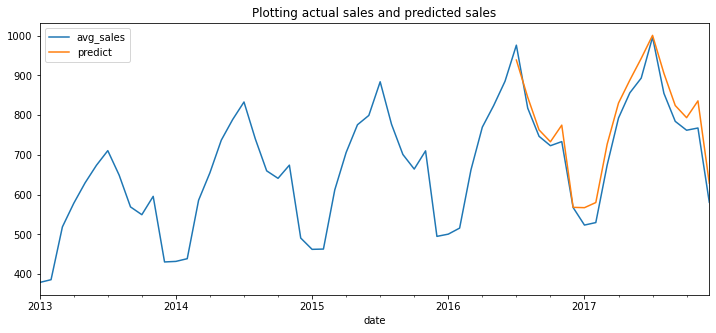

In [80]:
# item1['predict']=results.predict(start=pd.to_datetime('2016-07-01'),end=pd.to_datetime('2017-12-01'),dynamic=True)
# item1[['avg_sales','predict']].plot(figsize=(12,5))
item1['predict']=results.predict(start=42,end=60,dynamic=True)
item1[['avg_sales','predict']].plot(figsize=(12,5),title='Plotting actual sales and predicted sales')

### RMSE for evaluation of predicted sales when compared to actual sales

In [81]:
actual_val = item1.avg_sales[42:]
predicted_val = item1.predict[42:]
rmse = mean_squared_error(actual_val, predicted_val, squared = False)
print('RMSE: {}'.format(round(rmse,2)))

RMSE: 39.73


### Sales forecast of item1 for next 12 months

In [86]:
# setting the dates for future sales forecast for 12 months
future_dates=[item1.index[-1]+ DateOffset(months=x)for x in range(0,13)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=item1.columns)

<AxesSubplot:title={'center':'Sales forecast for 2018 for item1'}>

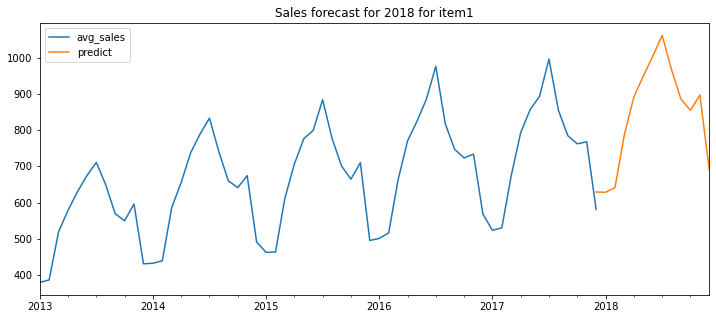

In [88]:
future_df=pd.concat([item1,future_datest_df])
future_df['predict'] = results.predict(start=59,end=73, dynamic= True)
future_df[['avg_sales', 'predict']].plot(figsize=(12, 5),title='Sales forecast for 2018 for item1')